#  EXAMPLE 4: Calculate the SPOD of large data and save results on hard drive.
The large-eddy simulation data provided along with this example is a subset of the database of a Mach 0.9 turbulent jet described in [1] and was calculated using the unstructured flow solver Charles developed at Cascade Technologies. If you are using the database in your research or teaching, please include explicit mention of Brès et al. [1]. The test database consists of 5000 snapshots of the symmetric component (m=0) of a round turbulent jet. A physical interpretaion of the SPOD results is given in [2], and a comprehensive discussion and derivation of SPOD and many of its properties can be found in [3].

### References:
1. G. A. Brès, P. Jordan, M. Le Rallic, V. Jaunet, A. V. G. Cavalieri, A. Towne, S. K. Lele, T. Colonius, O. T. Schmidt, Importance of the nozzle-exit boundary-layer state in subsonic turbulent jets, J. of Fluid Mech. 851, 83-124, 2018
2. Schmidt, O. T. and Towne, A. and Rigas, G. and Colonius, T. and Bres, G. A., Spectral analysis of jet turbulence, J. of Fluid Mech. 855, 953–982, 2018
3. Towne, A. and Schmidt, O. T. and Colonius, T., Spectral proper orthogonal decomposition and its relationship to dynamic mode decomposition and resolvent analysis, J. of Fluid Mech. 847, 821–867, 2018

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from spod import spod
from utils import trapzWeightsPolar, getjet
import os

In [2]:
# Note that we don't load the data 'p' itself.
f = h5py.File("jet_data/jetLES.mat", "r")
p_mean = np.swapaxes(f["p_mean"], 0, 1)
x = np.swapaxes(f["x"], 0, 1)
r = np.swapaxes(f["r"], 0, 1)
dt = f["dt"][0][0]
savefile = "results.hdf5"

### Memory-efficient SPOD version that stores and reloads FFT blocks from hard drive.
In this example, we use a function handle to provide individual snapshots to spod(). Additionally, we ask spod() to save the FFT blocks on hard drive instead of keeping all data in memory. These features enable the SPOD of very large data sets but require more computing time and additional hard drive space. We reduce the additional storage requirenment by saving only a few modes at selected frequencies.

In [3]:
# trapezoidal quadrature weights for cylindrical coordinates
intWeights = trapzWeightsPolar(r[:, 0], x[0, :])

# Use function handle getjet() to provide snapshots to spod(). The
# function getjet can be found in utils.py. You can use
# getjet() as a template to interface your own data with spod(). A
# default (Hamming) window of length 256 with 128 snaphots overlap is
# used in this example.
savefreqs = np.array([10, 15, 20]) - 1

result = spod(
    getjet,                 # use function to retrieve data
    window=256,             # Hamming window length 256
    weight=intWeights,      # trapezoidal quadrature weights
    noverlap=128,           # 128 snaphots overlap
    dt=dt,                  # specify dt
    mean=p_mean,            # provide a long-time mean
    nt=2000,                # use 2000 snapshots using getjet()
    debug=2,                # Verbose output
    lowmem=True,            # keep data on disk rather than memory (low-memory mode)
    savefile=savefile,      # save results to savefile
    nmodes=2,               # save the 2 most energetic modes
    savefreqs=savefreqs,    # save modes frequencies of indices [9 14 19]
)


SPOD parameters
------------------------------------
Spectrum type             : one-sided (real-valued signal)
No. of snaphots per block : 256
Block overlap             : 128
No. of blocks             : 14
Windowing fct. (time)     : Hamming
Weighting fct. (space)    : user_specified
Mean                      : user specified

Calculating temporal DFT
------------------------------------
block 1  / 14 (1:256)
block 2  / 14 (129:384)
block 3  / 14 (257:512)
block 4  / 14 (385:640)
block 5  / 14 (513:768)
block 6  / 14 (641:896)
block 7  / 14 (769:1024)
block 8  / 14 (897:1152)
block 9  / 14 (1025:1280)
block 10  / 14 (1153:1408)
block 11  / 14 (1281:1536)
block 12  / 14 (1409:1664)
block 13  / 14 (1537:1792)
block 14  / 14 (1665:1920)

Calculating SPOD
------------------------------------
frequency 10 / 129 (f=0.175781)
frequency 15 / 129 (f=0.273438)
frequency 20 / 129 (f=0.371094)


### Plot the SPOD spectrum and some modes as before.
Note that P is a function handle that loads the corresponding modes from hard drive since we are in FFT saving mode (OPTS.savefft is true).

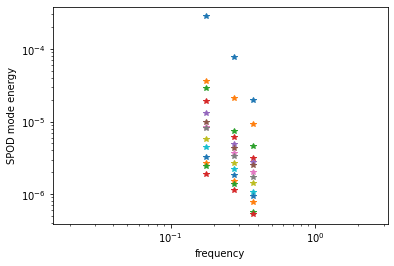

In [4]:
plt.figure()
plt.loglog(np.array(result["f"]), np.array(result["L"]), '*')
plt.xlabel("frequency")
plt.ylabel("SPOD mode energy")
plt.show()

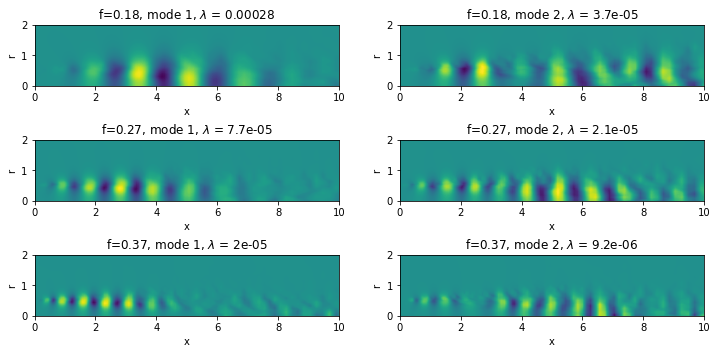

In [5]:
plt.figure(figsize=(12,6))
count = 1
for fi in savefreqs:
    for mi in range(2):
        plt.subplot(3, 2, count)
        P = np.real(result["P"][fi, :, :, mi])
        vmax = np.max(np.abs(P))
        plt.contourf(x, r, P, 256, vmin=-vmax, vmax=vmax)
        plt.axis("scaled")
        plt.xlabel("x")
        plt.ylabel("r")
        plt.title(
            "f=%.2f, mode %d, $\lambda$ = %.2g"
            % (result["f"][fi], mi + 1, result["L"][fi, mi])
        )
        plt.xlim(0, 10)
        plt.ylim(0, 2)
        count += 1

plt.show()

In [6]:
# Delete saved file
result.close()
os.remove(savefile)